Bridge chart




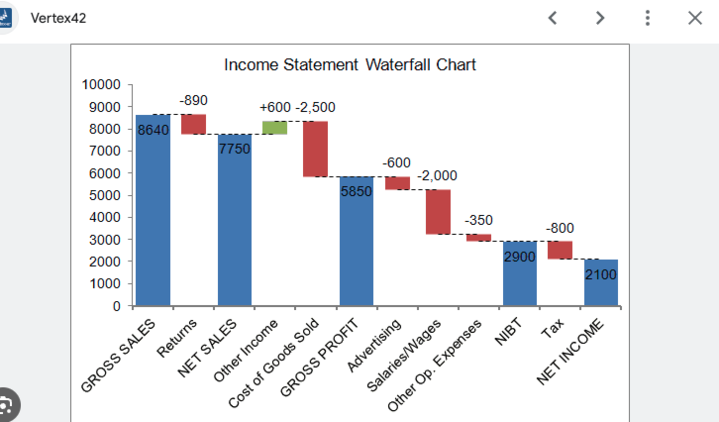


when we take fees that reduces nav/share because it increase the quantity of shares


#### For the previous month

Each of these modifies either Nav or shares, at each point

we need the nav and total shares are each of these points




- Autopool Total ETH value earned (current nav) - (expected nav if nav per share did not change)
- Total Eth taken in fees sum (ETH fees in each fee Event)
- Total ETH value lost in rebalance costs  (this increases NAV)
- Nav lost to 

<!-- 
This is another one - liquidation price of our incentives compared to the then existing price from our pricer -->

we care about the persent change in nav /share 

the bars (for both 1 & 2) are 1. net return annualized 2. gross return (before fees) 3. gross return (before fees & assuming no rebalance txn loss i.e. swap/slippage loss)

In [1]:
import pandas as pd
import streamlit as st
from datetime import timedelta
from multicall import Call
import plotly.express as px
import json

import numpy as np
import plotly.io as pio

pio.templates.default = None

from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    get_state_by_one_block,
    identity_with_bool_success,
    safe_normalize_with_bool_success,
    add_timestamp_to_df_with_block_column,
    build_blocks_to_use,
    eth_client,
)

from mainnet_launch.data_fetching.get_events import fetch_events

from mainnet_launch.constants import AUTO_ETH, AUTO_LRT, BAL_ETH, eth_client, AutopoolConstants
from mainnet_launch.abis.abis import AUTOPOOL_VAULT_ABI, AUTOPOOL_ETH_STRATEGY_ABI

import pandas as pd
import streamlit as st
from multicall import Call
from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    add_timestamp_to_df_with_block_column,
    build_blocks_to_use,
    safe_normalize_with_bool_success,
)
import plotly.express as px


def handle_getAssetBreakdown(success, AssetBreakdown):
    if success:
        totalIdle, totalDebt, totalDebtMin, totalDebtMin = AssetBreakdown
        return int(totalIdle + totalDebt) / 1e18
    return None


def getAssetBreakdown_call(name: str, autopool_vault_address: str) -> Call:
    return Call(
        autopool_vault_address,
        ["getAssetBreakdown()((uint256,uint256,uint256,uint256))"],
        [(name, handle_getAssetBreakdown)],
    )


def totalSupply_call(name: str, autopool_vault_address: str) -> Call:
    return Call(
        autopool_vault_address,
        ["totalSupply()(uint256)"],
        [(name, safe_normalize_with_bool_success)],
    )


def build_actual_nav_per_share_df(autopool: AutopoolConstants) -> pd.DataFrame:

    calls = [
        getAssetBreakdown_call("actual_nav", autopool.autopool_eth_addr),
        totalSupply_call("actual_shares", autopool.autopool_eth_addr),
    ]
    blocks = build_blocks_to_use()
    df = get_raw_state_by_blocks(calls, blocks)
    df["actual_nav_per_share"] = df["actual_nav"] / df["actual_shares"]
    daily_nav_shares_df = df.resample("1D").last()
    return daily_nav_shares_df


def build_fee_shares_minted_df(autopool: AutopoolConstants):
    autoETH_vault = eth_client.eth.contract(autopool.autopool_eth_addr, abi=AUTOPOOL_VAULT_ABI)
    FeeCollected_df = add_timestamp_to_df_with_block_column(fetch_events(autoETH_vault.events.FeeCollected))
    PeriodicFeeCollected_df = add_timestamp_to_df_with_block_column(
        fetch_events(autoETH_vault.events.PeriodicFeeCollected)
    )
    PeriodicFeeCollected_df["new_shares_from_periodic_fees"] = PeriodicFeeCollected_df["mintedShares"] / 1e18
    FeeCollected_df["new_shares_from_streaming_fees"] = FeeCollected_df["mintedShares"] / 1e18
    fee_df = pd.concat(
        [
            PeriodicFeeCollected_df[["new_shares_from_periodic_fees"]],
            FeeCollected_df[["new_shares_from_streaming_fees"]],
        ]
    )
    daily_fee_share_df = fee_df.resample("1D").sum()
    return daily_fee_share_df.cumsum()


daily_fee_share_df = build_fee_shares_minted_df(AUTO_ETH)
daily_nav_shares_df = build_actual_nav_per_share_df(AUTO_ETH)
df = daily_nav_shares_df.join(daily_fee_share_df, how="left").fillna(0)

from mainnet_launch.solver_diagnostics.fetch_rebalance_events import fetch_and_clean_rebalance_between_destination_events

rebalance_df = fetch_and_clean_rebalance_between_destination_events(AUTO_ETH)
daily_nav_lost_to_rebalances = (rebalance_df[['swapCost']].resample('1D').sum()).cumsum()
daily_nav_lost_to_rebalances.columns = ['eth_nav_lost_by_rebalance_between_destinations']
df = df.join(daily_nav_lost_to_rebalances, how="left").fillna(0)
df.head()

2024-10-23 14:46:41.558 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-23 14:46:43.731 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 14:46:43.894 
  command:

    streamlit run /home/parker/Documents/Tokemak/v2-rebalance-dashboard/.venv/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-10-23 14:46:43.895 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 14:46:43.895 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 14:46:43.896 No runtime found, using MemoryCacheStorageManager
2024-10-23 14:46:43.976 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 14:46:43.976 Thread 'MainThread': missing Sc

,actual_nav,actual_shares,actual_nav_per_share,new_shares_from_periodic_fees,new_shares_from_streaming_fees,eth_nav_lost_by_rebalance_between_destinations
timestamp,,,,,,
2024-09-15 00:00:00+00:00,0.176129,0.176129,1.000000,0.00000,0.0,0.000000
2024-09-16 00:00:00+00:00,902.012316,902.012316,1.000000,0.00000,0.0,0.000000
2024-09-17 00:00:00+00:00,1653.384535,1653.392359,0.999995,0.00000,0.0,0.033739
2024-09-18 00:00:00+00:00,2993.877068,2994.157550,0.999906,0.00000,0.0,0.213260
2024-09-19 00:00:00+00:00,3901.645343,3903.814760,0.999444,0.62561,0.0,1.172403


In [2]:
round(.07 * (30/365) * .01, 6)

5.8e-05

In [3]:
px.line(df['eth_nav_lost_by_rebalance_between_destinations'])

In [4]:
px.line

<function plotly.express._chart_types.line(data_frame=None, x=None, y=None, line_group=None, color=None, line_dash=None, symbol=None, hover_name=None, hover_data=None, custom_data=None, text=None, facet_row=None, facet_col=None, facet_col_wrap=0, facet_row_spacing=None, facet_col_spacing=None, error_x=None, error_x_minus=None, error_y=None, error_y_minus=None, animation_frame=None, animation_group=None, category_orders=None, labels=None, orientation=None, color_discrete_sequence=None, color_discrete_map=None, line_dash_sequence=None, line_dash_map=None, symbol_sequence=None, symbol_map=None, markers=False, log_x=False, log_y=False, range_x=None, range_y=None, line_shape=None, render_mode='auto', title=None, template=None, width=None, height=None) -> plotly.graph_objs._figure.Figure>

In [5]:
print(5.8e-05)

5.8e-05


In [6]:
0.000058

5.8e-05

In [7]:
# losing some nav means we dont autocompound as as much as we would otherwise
# ignoring this for now for simplicity. Should not matter very much 
# at a 7% rate of return over 30 days, if we lose 1% of nav in that way
# the lost compounding is .07 * (30/365) * .01  = 0.000058 apy (about half a basis point over a year if there is a 1% nav loss over that month from rebalances, most extreme case)
# too small to worry about. 

df["nav_per_share_if_no_fees"] = df["actual_nav"] / (
    df["actual_shares"] - df["new_shares_from_periodic_fees"] - df["new_shares_from_streaming_fees"]
)
df['nav_per_share_if_no_value_lost_from_rebalances'] = (df['actual_nav'] + df['eth_nav_lost_by_rebalance_between_destinations']) / df['actual_shares']


px.line(df[['nav_per_share_if_no_value_lost_from_rebalances', 'nav_per_share_if_no_fees', 'actual_nav_per_share']])

In [8]:
def add_30_day_annualized_return_col(df: pd.DataFrame, col: str):
    df[f"{col}_30_day_annualized_return"] = (df[col].diff(periods=30) / df[col].shift(30)) * (365 / 30) * 100

add_30_day_annualized_return_col(df, "actual_nav_per_share")
add_30_day_annualized_return_col(df, "nav_per_share_if_no_fees")
add_30_day_annualized_return_col(df, "nav_per_share_if_no_value_lost_from_rebalances")

px.line(df[["nav_per_share_if_no_fees_30_day_annualized_return", "actual_nav_per_share_30_day_annualized_return", 'nav_per_share_if_no_value_lost_from_rebalances_30_day_annualized_return']])

In [9]:
vault_contract = eth_client.eth.contract(AUTO_ETH.autopool_eth_addr, abi=AUTOPOOL_VAULT_ABI)
rewardsliq = fetch_events(vault_contract.events.DestinationDebtReporting)
rewardsliq

,destination,debtInfo,claimed,claimGasUsed,event,block,transaction_index,log_index,hash
0,0xE382BBd32C4E202185762eA433278f4ED9E6151E,"(True, 0, 0, 414396248259951398280, 4143695129...",0,492350,DestinationDebtReporting,20782123,147,362,0x39a5a532b0f070668ab5076aa5717b607149c93a219c...
1,0xd96E943098B2AE81155e98D7DC8BeaB34C539f01,"(True, 0, 0, 280688392880098872407, 2806897686...",0,396639,DestinationDebtReporting,20782123,147,364,0x39a5a532b0f070668ab5076aa5717b607149c93a219c...
2,0xd96E943098B2AE81155e98D7DC8BeaB34C539f01,"(True, 0, 0, 280647818396993667637, 2806883928...",49341239610598684,674969,DestinationDebtReporting,20789288,196,695,0x62221b0f09863e8cf60f582dc1d26e44feef4aa1ad79...
3,0xE382BBd32C4E202185762eA433278f4ED9E6151E,"(True, 0, 0, 750055284549229694347, 7500908019...",197333353426279214,369881,DestinationDebtReporting,20789288,196,699,0x62221b0f09863e8cf60f582dc1d26e44feef4aa1ad79...
4,0xC001f23397dB71B17602Ce7D90a983Edc38DB0d1,"(True, 0, 0, 399231905705283421671, 3992000490...",0,353663,DestinationDebtReporting,20789288,196,701,0x62221b0f09863e8cf60f582dc1d26e44feef4aa1ad79...
...,...,...,...,...,...,...,...,...,...
376,0xc4Eb861e7b66f593482a3D7E8adc314f6eEDA30B,"(True, 0, 0, 2597788714171627754848, 259797171...",4994970786279151,396432,DestinationDebtReporting,21029155,158,813,0x0af435f4b925d062360cf041d8c36509aebff1c1e9c7...
377,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,"(True, 0, 0, 1508477093264522471177, 150839709...",0,396429,DestinationDebtReporting,21029155,158,815,0x0af435f4b925d062360cf041d8c36509aebff1c1e9c7...
378,0xbA1462f43c6f60ebD1C62735c94E428aD073E01A,"(True, 0, 0, 2234304345118857574341, 223446174...",209519109275657961,331658,DestinationDebtReporting,21029155,158,819,0x0af435f4b925d062360cf041d8c36509aebff1c1e9c7...
379,0x2B08137BeABd2454AD3631DEB754F97C5c93eB78,"(True, 0, 0, 206371966826764858530, 2063641882...",0,290637,DestinationDebtReporting,21029155,158,821,0x0af435f4b925d062360cf041d8c36509aebff1c1e9c7...


In [10]:
rewardsliq.iloc[3].values

array(['0xE382BBd32C4E202185762eA433278f4ED9E6151E',
       (True, 0, 0, 750055284549229694347, 750090801973207204929, 750033653034124925810, 750087766004224023981, 750076916064334462885, 750093837942190385877),
       np.int64(197333353426279214), np.int64(369881),
       'DestinationDebtReporting', np.int64(20789288), np.int64(196),
       np.int64(699),
       '0x62221b0f09863e8cf60f582dc1d26e44feef4aa1ad790b839ecaa596be5d227b'],
      dtype=object)

in this tx https://dashboard.tenderly.co/tx/mainnet/0x62221b0f09863e8cf60f582dc1d26e44feef4aa1ad790b839ecaa596be5d227b/state-diff
autoETH had it's WETH balacne increase

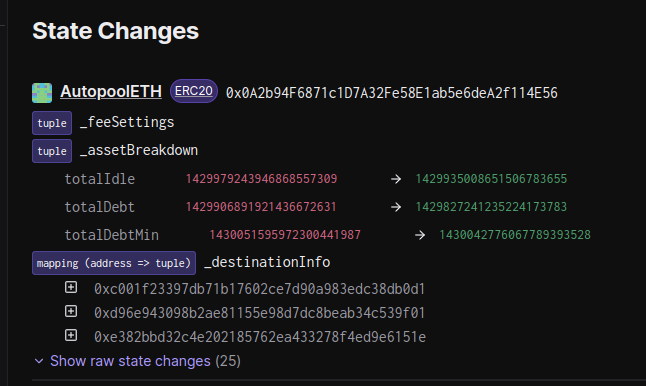




![
    

](attachment:image.png)



0xbf58810bb1946429830c1f12205331608c470ff5   
Name
Swapped (index_topic_1 address sellTokenAddress, index_topic_2 address buyTokenAddress, uint256 sellAmount, uint256 buyAmount, uint256 buyTokenAmountReceived)View Source

Topics
0 0xa54201e99d8e1488291e015a3af88c7a169bcf4932617ecd9536e1f1ad435110
1: sellTokenAddress
0xD533a949740bb3306d119CC777fa900bA034cd52
2: buyTokenAddress
0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2
Data
sellAmount :9613693224373079172405
buyAmount :979152628465652190
buyTokenAmountReceived :979152628465652208

In [11]:
rewardsliq

,destination,debtInfo,claimed,claimGasUsed,event,block,transaction_index,log_index,hash
0,0xE382BBd32C4E202185762eA433278f4ED9E6151E,"(True, 0, 0, 414396248259951398280, 4143695129...",0,492350,DestinationDebtReporting,20782123,147,362,0x39a5a532b0f070668ab5076aa5717b607149c93a219c...
1,0xd96E943098B2AE81155e98D7DC8BeaB34C539f01,"(True, 0, 0, 280688392880098872407, 2806897686...",0,396639,DestinationDebtReporting,20782123,147,364,0x39a5a532b0f070668ab5076aa5717b607149c93a219c...
2,0xd96E943098B2AE81155e98D7DC8BeaB34C539f01,"(True, 0, 0, 280647818396993667637, 2806883928...",49341239610598684,674969,DestinationDebtReporting,20789288,196,695,0x62221b0f09863e8cf60f582dc1d26e44feef4aa1ad79...
3,0xE382BBd32C4E202185762eA433278f4ED9E6151E,"(True, 0, 0, 750055284549229694347, 7500908019...",197333353426279214,369881,DestinationDebtReporting,20789288,196,699,0x62221b0f09863e8cf60f582dc1d26e44feef4aa1ad79...
4,0xC001f23397dB71B17602Ce7D90a983Edc38DB0d1,"(True, 0, 0, 399231905705283421671, 3992000490...",0,353663,DestinationDebtReporting,20789288,196,701,0x62221b0f09863e8cf60f582dc1d26e44feef4aa1ad79...
...,...,...,...,...,...,...,...,...,...
376,0xc4Eb861e7b66f593482a3D7E8adc314f6eEDA30B,"(True, 0, 0, 2597788714171627754848, 259797171...",4994970786279151,396432,DestinationDebtReporting,21029155,158,813,0x0af435f4b925d062360cf041d8c36509aebff1c1e9c7...
377,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,"(True, 0, 0, 1508477093264522471177, 150839709...",0,396429,DestinationDebtReporting,21029155,158,815,0x0af435f4b925d062360cf041d8c36509aebff1c1e9c7...
378,0xbA1462f43c6f60ebD1C62735c94E428aD073E01A,"(True, 0, 0, 2234304345118857574341, 223446174...",209519109275657961,331658,DestinationDebtReporting,21029155,158,819,0x0af435f4b925d062360cf041d8c36509aebff1c1e9c7...
379,0x2B08137BeABd2454AD3631DEB754F97C5c93eB78,"(True, 0, 0, 206371966826764858530, 2063641882...",0,290637,DestinationDebtReporting,21029155,158,821,0x0af435f4b925d062360cf041d8c36509aebff1c1e9c7...


In [17]:
swapped_event_abi =json.loads("""[{"inputs":[{"internalType":"address","name":"aggregator","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[{"internalType":"uint256","name":"balanceNeeded","type":"uint256"},{"internalType":"uint256","name":"balanceAvailable","type":"uint256"}],"type":"error","name":"InsufficientBalance"},{"inputs":[],"type":"error","name":"InsufficientBuyAmount"},{"inputs":[{"internalType":"uint256","name":"buyTokenAmountReceived","type":"uint256"},{"internalType":"uint256","name":"buyAmount","type":"uint256"}],"type":"error","name":"InsufficientBuyAmountReceived"},{"inputs":[],"type":"error","name":"InsufficientSellAmount"},{"inputs":[],"type":"error","name":"SwapFailed"},{"inputs":[],"type":"error","name":"TokenAddressZero"},{"inputs":[{"internalType":"address","name":"sellTokenAddress","type":"address","indexed":true},{"internalType":"address","name":"buyTokenAddress","type":"address","indexed":true},{"internalType":"uint256","name":"sellAmount","type":"uint256","indexed":false},{"internalType":"uint256","name":"buyAmount","type":"uint256","indexed":false},{"internalType":"uint256","name":"buyTokenAmountReceived","type":"uint256","indexed":false}],"type":"event","name":"Swapped","anonymous":false},{"inputs":[],"stateMutability":"view","type":"function","name":"AGGREGATOR","outputs":[{"internalType":"address","name":"","type":"address"}]},{"inputs":[{"internalType":"struct SwapParams","name":"swapParams","type":"tuple","components":[{"internalType":"address","name":"sellTokenAddress","type":"address"},{"internalType":"uint256","name":"sellAmount","type":"uint256"},{"internalType":"address","name":"buyTokenAddress","type":"address"},{"internalType":"uint256","name":"buyAmount","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"},{"internalType":"bytes","name":"extraData","type":"bytes"},{"internalType":"uint256","name":"deadline","type":"uint256"}]}],"stateMutability":"nonpayable","type":"function","name":"swap","outputs":[{"internalType":"uint256","name":"buyTokenAmountReceived","type":"uint256"}]}]""")
swapped_event_abi

[{'inputs': [{'internalType': 'address',
    'name': 'aggregator',
    'type': 'address'}],
  'stateMutability': 'nonpayable',
  'type': 'constructor'},
 {'inputs': [{'internalType': 'uint256',
    'name': 'balanceNeeded',
    'type': 'uint256'},
   {'internalType': 'uint256', 'name': 'balanceAvailable', 'type': 'uint256'}],
  'type': 'error',
  'name': 'InsufficientBalance'},
 {'inputs': [], 'type': 'error', 'name': 'InsufficientBuyAmount'},
 {'inputs': [{'internalType': 'uint256',
    'name': 'buyTokenAmountReceived',
    'type': 'uint256'},
   {'internalType': 'uint256', 'name': 'buyAmount', 'type': 'uint256'}],
  'type': 'error',
  'name': 'InsufficientBuyAmountReceived'},
 {'inputs': [], 'type': 'error', 'name': 'InsufficientSellAmount'},
 {'inputs': [], 'type': 'error', 'name': 'SwapFailed'},
 {'inputs': [], 'type': 'error', 'name': 'TokenAddressZero'},
 {'inputs': [{'internalType': 'address',
    'name': 'sellTokenAddress',
    'type': 'address',
    'indexed': True},
   {'inter

In [18]:
LiquidationRow_address =  '0xBf58810BB1946429830C1f12205331608c470ff5'
abi = json.loads("""[{"inputs":[{"internalType":"contract ISystemRegistry","name":"_systemRegistry","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"AccessDenied","type":"error"},{"inputs":[{"internalType":"uint256","name":"sellAmount","type":"uint256"},{"internalType":"uint256","name":"buyAmount","type":"uint256"}],"name":"AmountsMismatch","type":"error"},{"inputs":[{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint256","name":"currentTimestamp","type":"uint256"}],"name":"DeadlineExceeded","type":"error"},{"inputs":[],"name":"FeeTooHigh","type":"error"},{"inputs":[{"internalType":"uint256","name":"expectedAmount","type":"uint256"},{"internalType":"uint256","name":"amountReceived","type":"uint256"}],"name":"InsufficientAmountReceived","type":"error"},{"inputs":[{"internalType":"address","name":"token","type":"address"}],"name":"InsufficientBalance","type":"error"},{"inputs":[{"internalType":"string","name":"paramName","type":"string"}],"name":"InvalidParam","type":"error"},{"inputs":[],"name":"InvalidRewardToken","type":"error"},{"inputs":[],"name":"ItemExists","type":"error"},{"inputs":[],"name":"ItemNotFound","type":"error"},{"inputs":[],"name":"NothingToLiquidate","type":"error"},{"inputs":[{"internalType":"uint256","name":"totalBalanceToLiquidate","type":"uint256"},{"internalType":"uint256","name":"buyAmount","type":"uint256"}],"name":"SellAmountMismatch","type":"error"},{"inputs":[],"name":"UndefinedAddress","type":"error"},{"inputs":[{"internalType":"string","name":"paramName","type":"string"}],"name":"ZeroAddress","type":"error"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"token","type":"address"},{"indexed":true,"internalType":"address","name":"vault","type":"address"},{"indexed":false,"internalType":"uint256","name":"balance","type":"uint256"}],"name":"BalanceUpdated","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"feeReceiver","type":"address"},{"indexed":false,"internalType":"uint256","name":"feeBps","type":"uint256"}],"name":"FeeReceiverSet","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"receiver","type":"address"},{"indexed":false,"internalType":"uint256","name":"amountReceived","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"fees","type":"uint256"}],"name":"FeesTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"vault","type":"address"},{"indexed":false,"internalType":"uint256","name":"gasAmount","type":"uint256"},{"indexed":false,"internalType":"bytes32","name":"action","type":"bytes32"}],"name":"GasUsedForVault","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"priceMarginBps","type":"uint256"}],"name":"PriceMarginSet","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"swapper","type":"address"}],"name":"SwapperAdded","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"swapper","type":"address"}],"name":"SwapperRemoved","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"vault","type":"address"},{"indexed":true,"internalType":"address","name":"fromToken","type":"address"},{"indexed":true,"internalType":"address","name":"toToken","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"VaultLiquidated","type":"event"},{"inputs":[],"name":"MAX_PCT","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"accessController","outputs":[{"internalType":"contract IAccessController","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"swapper","type":"address"}],"name":"addToWhitelist","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"tokenAddress","type":"address"},{"internalType":"address","name":"vaultAddress","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"calculateFee","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"contract IDestinationVault[]","name":"vaults","type":"address[]"}],"name":"claimsVaultRewards","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"feeBps","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeReceiver","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getSystemRegistry","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getTokens","outputs":[{"internalType":"address[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"tokenAddress","type":"address"}],"name":"getVaultsForToken","outputs":[{"internalType":"address[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"swapper","type":"address"}],"name":"isWhitelisted","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"components":[{"internalType":"address","name":"fromToken","type":"address"},{"internalType":"address","name":"asyncSwapper","type":"address"},{"internalType":"contract IDestinationVault[]","name":"vaultsToLiquidate","type":"address[]"},{"components":[{"internalType":"address","name":"sellTokenAddress","type":"address"},{"internalType":"uint256","name":"sellAmount","type":"uint256"},{"internalType":"address","name":"buyTokenAddress","type":"address"},{"internalType":"uint256","name":"buyAmount","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"},{"internalType":"bytes","name":"extraData","type":"bytes"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"internalType":"struct SwapParams","name":"param","type":"tuple"}],"internalType":"struct ILiquidationRow.LiquidationParams","name":"liquidationParams","type":"tuple"}],"name":"liquidateVaultsForToken","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"components":[{"internalType":"address","name":"fromToken","type":"address"},{"internalType":"address","name":"asyncSwapper","type":"address"},{"internalType":"contract IDestinationVault[]","name":"vaultsToLiquidate","type":"address[]"},{"components":[{"internalType":"address","name":"sellTokenAddress","type":"address"},{"internalType":"uint256","name":"sellAmount","type":"uint256"},{"internalType":"address","name":"buyTokenAddress","type":"address"},{"internalType":"uint256","name":"buyAmount","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"},{"internalType":"bytes","name":"extraData","type":"bytes"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"internalType":"struct SwapParams","name":"param","type":"tuple"}],"internalType":"struct ILiquidationRow.LiquidationParams[]","name":"liquidationParams","type":"tuple[]"}],"name":"liquidateVaultsForTokens","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"priceMarginBps","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"swapper","type":"address"}],"name":"removeFromWhitelist","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_feeReceiver","type":"address"},{"internalType":"uint256","name":"_feeBps","type":"uint256"}],"name":"setFeeAndReceiver","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_priceMarginBps","type":"uint256"}],"name":"setPriceMarginBps","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"tokenAddress","type":"address"}],"name":"totalBalanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"}]""")


contract = eth_client.eth.contract(LiquidationRow_address, abi=swapped_event_abi)
for e in contract.events:
    print(e)

<class 'web3._utils.datatypes.Swapped'>


In [19]:
swapped = add_timestamp_to_df_with_block_column(fetch_events(contract.events.Swapped))
swapped

,sellTokenAddress,buyTokenAddress,sellAmount,buyAmount,buyTokenAmountReceived,event,block,transaction_index,log_index,hash
timestamp,,,,,,,,,,
2024-09-19 19:06:47+00:00,0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,405885564600978683213,65660904437741059,65660904437741083,Swapped,20786622,89,212,0xeaff1c935812795d7c751554c06a6f725d0523fe985d...
2024-09-19 19:06:47+00:00,0xba100000625a3754423978a60c9317c58a424e3D,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,97656862179630371841,73583617510509109,73583617510509114,Swapped,20786622,89,239,0xeaff1c935812795d7c751554c06a6f725d0523fe985d...
2024-09-19 19:06:47+00:00,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,305110013,123151123466434536,123151125084164991,Swapped,20786622,89,263,0xeaff1c935812795d7c751554c06a6f725d0523fe985d...
2024-09-19 19:06:47+00:00,0x4e3FBD56CD56c3e72c1403e103b45Db9da5B9D2B,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,6322527432225350368,5347173311905731,5347173311905731,Swapped,20786622,89,283,0xeaff1c935812795d7c751554c06a6f725d0523fe985d...
2024-09-19 19:06:47+00:00,0xD533a949740bb3306d119CC777fa900bA034cd52,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,2107509144075116791221,241327419724972605,241327419724972627,Swapped,20786622,89,307,0xeaff1c935812795d7c751554c06a6f725d0523fe985d...
...,...,...,...,...,...,...,...,...,...,...
2024-10-23 18:25:23+00:00,0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,230075718504148264860,29500264061930152,30102310267275687,Swapped,21030067,30,119,0xa25f1f5d8e28d5a6939a97f768fad5464a2c2056962b...
2024-10-23 18:25:23+00:00,0xba100000625a3754423978a60c9317c58a424e3D,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,70145835830068598221,51290886299728388,52337639081355498,Swapped,21030067,30,160,0xa25f1f5d8e28d5a6939a97f768fad5464a2c2056962b...
2024-10-23 18:25:23+00:00,0x6DF0E641FC9847c0c6Fde39bE6253045440c14d3,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,12658867802831196772278,200772289324698227,204869682984385962,Swapped,21030067,30,198,0xa25f1f5d8e28d5a6939a97f768fad5464a2c2056962b...


In [13]:
from mainnet_launch.abis.abi_signature_from_abi_utils import get_function_and_event_signatures_with_returns

get_function_and_event_signatures_with_returns(abi)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 'BalanceUpdated(address,address,uint256)',
 'FeeReceiverSet(address,uint256)',
 'FeesTransferred(address,uint256,uint256)',
 'GasUsedForVault(address,uint256,bytes32)',
 'PriceMarginSet(uint256)',
 'SwapperAdded(address)',
 'SwapperRemoved(address)',
 'VaultLiquidated(address,address,address,uint256)',
 'MAX_PCT()(uint256)',
 'accessController()(address)',
 'addToWhitelist(address)',
 'balanceOf(address,address)(uint256)',
 'calculateFee(uint256)(uint256)',
 'claimsVaultRewards(address[])',
 'feeBps()(uint256)',
 'feeReceiver()(address)',
 'getSystemRegistry()(address)',
 'getTokens()(address[])',
 'getVaultsForToken(address)(address[])',
 'isWhitelisted(address)(bool)',
 'liquidateVaultsForToken((address,address,address[],(address,uint256,address,uint256,bytes,bytes,uint256)))',
 'liquidateVaultsForTokens((address,address,address[],(address,uint256,address,uint256,bytes,bytes,uint

In [ ]:
ab

,swapper,event,block,transaction_index,log_index,hash
timestamp,,,,,,
2024-09-12 17:03:23+00:00,0xBD9e1c43638590Ba64605483c761498EB7Dd6DB9,SwapperAdded,20735898,165,471,0x594df0de0b2bf3884126cc4fb182d4fb7de904a18373...
2024-09-12 17:03:35+00:00,0x957243d1cB359A685d90332363a51BA6588F5192,SwapperAdded,20735899,169,449,0x8db13d7b9cf0ea211bc89ed36fca257dc5de1f00b0d2...
2024-09-12 17:03:47+00:00,0x2164005A8885cb60824F69c96C0f97a54d4AB9C5,SwapperAdded,20735900,93,285,0xd00bf8b0964d04782378cf096d25321d2acd22abc790...
2024-10-17 16:32:59+00:00,0x8821a5c4f808d970de5bB2C31379c67CD67Cf6B8,SwapperAdded,20986503,12,139,0x2da3bd47e4c3cec464146f5185dac9a871ccf93f9279...
